## Quick Exploration on Individual Household Electric Power Consumption Data Set

### Purpose
This notebook is used to explore the dataset and extract some interesting facts. The procedure is something like
1. Explore the data
2. Visualize Data and Feature
3. Predict Something
4. Extract Interesting Idea
......

If any questions, feel free to email linhai_li@hotmail.com

citation: the dataset is the machine learning dataset from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#

Note: This notebook was created and tested under Python 3.7. The packages of pandas, numpy, matplotlib, statsmodels, sklearn are required.

In [1]:
from datetime import date
from IPython.display import display

import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot, register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error

register_matplotlib_converters()

%matplotlib inline

## Import and Preprocess Data

In [3]:
#Import Data
#Please download the dataset and unzip to the same directory of this notebook
house_power = pd.read_csv('household_power_consumption.txt', delimiter=';', header=0, 
                          na_values=['','?'], dtype=float, parse_dates={'Datetime':[0,1]},
                          infer_datetime_format=True, memory_map=True)

In [4]:
#Convert the unit of the active and reactive power to the same as sub_meters, watt-hour
house_power['Global_active_power'] = house_power['Global_active_power']*1000/60
house_power['Global_reactive_power'] = house_power['Global_reactive_power']*1000/60

#Compute the portion of Global active power not measured by the sub-meters
house_power['Other'] = house_power['Global_active_power'] - house_power['Sub_metering_1'] \
                      - house_power['Sub_metering_2'] - house_power['Sub_metering_3']

#Fill the missing value by the mean of the same Month-Day Hour-Minute, assuming similarity in monthly and daily usage
house_power['Fill_na_key'] = house_power['Datetime'].dt.strftime('%m-%d %H:%M:%S')
miss_value_idx = house_power.isna().sum(axis=1)>0
miss_value_keys = house_power[miss_value_idx]['Fill_na_key'].unique()
fillna = house_power[house_power['Fill_na_key'].isin(miss_value_keys)].groupby('Fill_na_key', sort=False).apply(lambda df: df.fillna(df.mean(axis=0)))
house_power[miss_value_idx] = fillna.reset_index(level=0, drop=True).sort_values('Datetime')[miss_value_idx]
house_power.drop(columns='Fill_na_key', inplace=True)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [5]:
house_power.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Other
0,2006-12-16 17:24:00,70.266667,6.966667,234.84,18.4,0.0,1.0,17.0,52.266667
1,2006-12-16 17:25:00,89.333333,7.266667,233.63,23.0,0.0,1.0,16.0,72.333333
2,2006-12-16 17:26:00,89.566667,8.300000,233.29,23.0,0.0,2.0,17.0,70.566667
3,2006-12-16 17:27:00,89.800000,8.366667,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,61.100000,8.800000,235.68,15.8,0.0,1.0,17.0,43.100000


## Visualize the raw data to get general picture of the data set

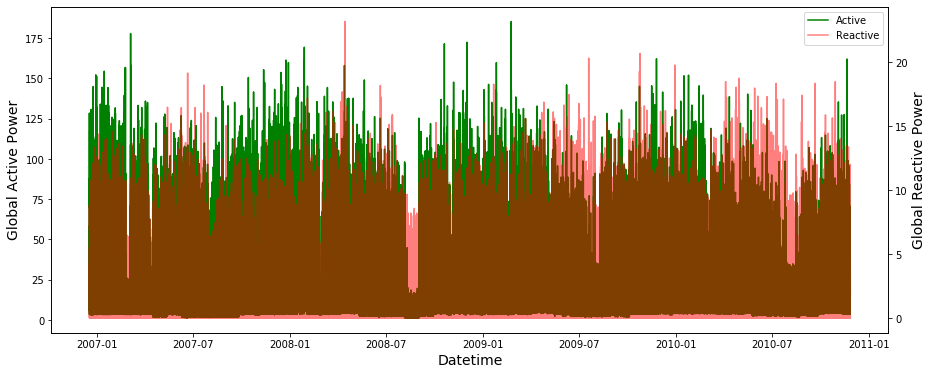

In [6]:
# Plot the active and reactive power
fig, ax = plt.subplots(1,1,figsize=(15,6))
line1 = ax.plot(house_power['Datetime'].values, house_power['Global_active_power'], 'g-', label='Active')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Global Active Power', fontsize=14)

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax1 = ax.twinx()
line2 = ax1.plot(house_power['Datetime'].values, house_power['Global_reactive_power'], 'r-', alpha=0.5, label='Reactive')
ax1.set_ylabel('Global Reactive Power', fontsize=14)

## Add legend
lines = line1+line2
labs = [l.get_label() for l in lines]
plt.legend(lines, labs, loc=1)

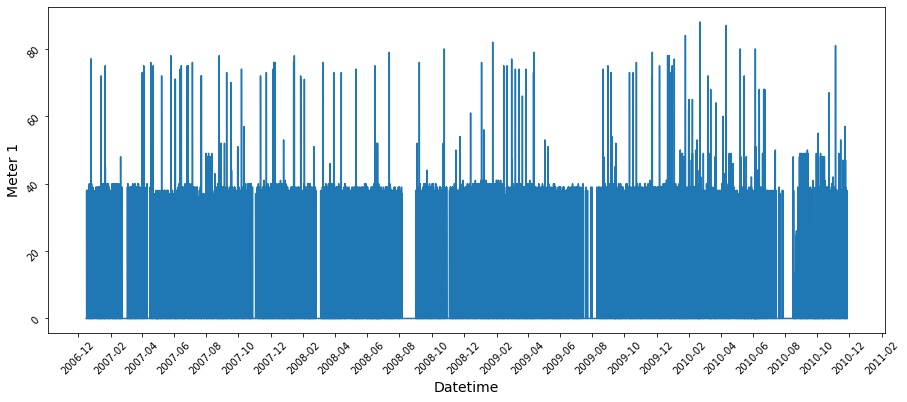

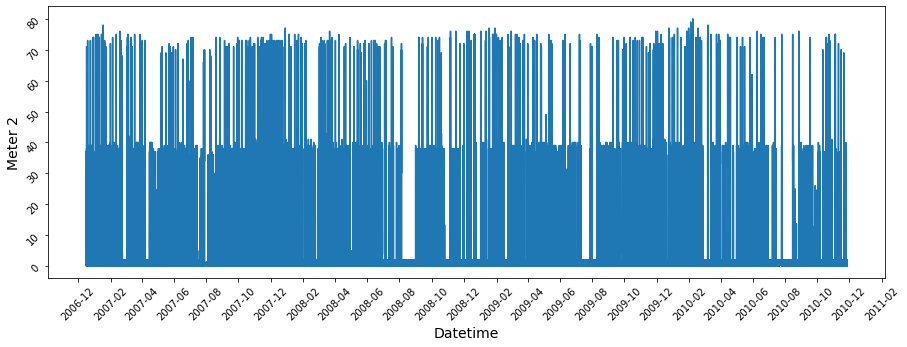

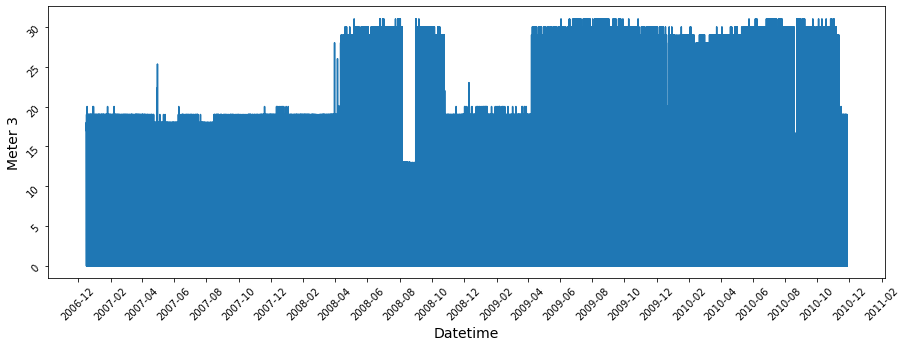

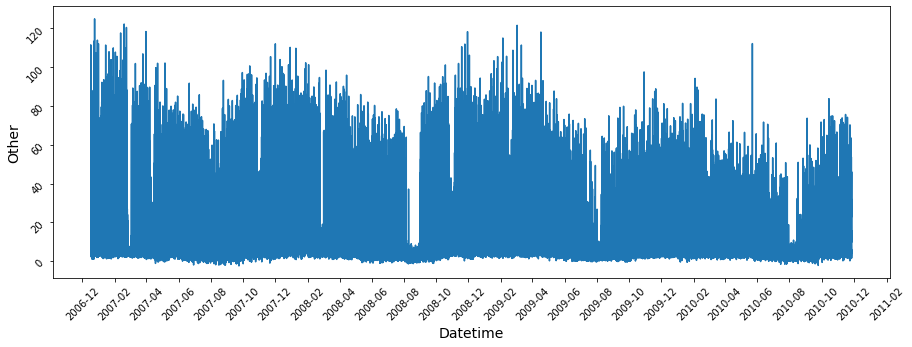

In [7]:
# Look at the sub_meter1
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_1'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 1', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(rotation=45)

#Look at the sub_meter2
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_2'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 2', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(rotation=45)

#Look at the sub_meter3
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_3'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 3', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(rotation=45)

#Look at the rest of power
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(house_power['Datetime'].values,house_power['Other'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Other', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(rotation=45)

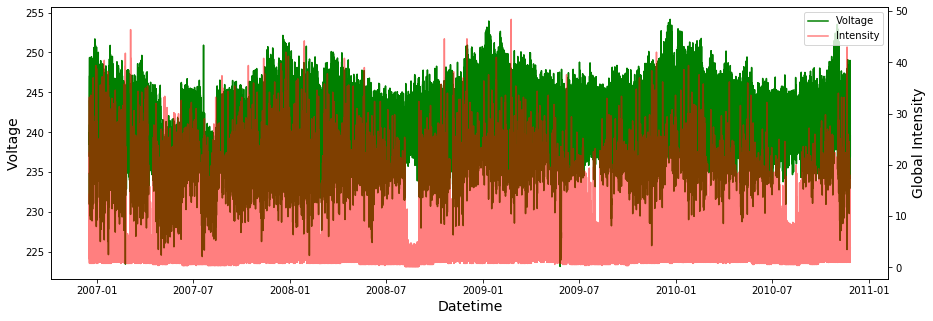

In [8]:
# Look at the Voltage and Intensity
fig, ax = plt.subplots(1,1,figsize=(15,5))
line1 = ax.plot(house_power['Datetime'].values, house_power['Voltage'], 'g-', label='Voltage')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Voltage', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax1 = ax.twinx()
line2 = ax1.plot(house_power['Datetime'].values, house_power['Global_intensity'], 'r-', alpha=0.5, label='Intensity')
ax1.set_ylabel('Global Intensity', fontsize=14)

# added these three lines
lines = line1+line2
labs = [l.get_label() for l in lines]

plt.legend(lines, labs, loc=1)

### A few points based on the visualization of the raw data
1. It seems some measurements exhibit seasonality, such as Global_active_power, "Other" (power not measured), Voltage and Intensity.
2. There are huge dips on most of the measurements, such as all the sub-meters and global active power. What are these dips?
3. Sub-meter 3 shows dramatic increase after around April, 2008. What causes this? High fluctuation noise in the minute-level measurements?

## Binning the Data to Days
   for two reasons: 1) Reduce noise in measurements; 2) I won't focus on the minute-level features later

In [9]:
#Bin the measurements to daily
def binByDay(df):
    tmp = df.sum(axis=0)
    tmp['Voltage'] = df['Voltage'].mean()
    tmp['Global_intensity'] = df['Global_intensity'].mean()
    return tmp

house_power['Datetime'] = pd.to_datetime(house_power['Datetime'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
house_power = house_power.groupby('Datetime', sort=False).apply(binByDay).reset_index()
house_power.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Other
0,2006-12-16,20152.933333,582.033333,236.243763,13.082828,0.0,546.0,4926.0,14680.933333
1,2006-12-17,56507.666667,3766.766667,240.087028,9.999028,2033.0,4187.0,13341.0,36946.666667
2,2006-12-18,36730.433333,2696.533333,241.231694,6.421667,1063.0,2621.0,14018.0,19028.433333
3,2006-12-19,27769.900000,2515.700000,241.999313,4.926389,839.0,7602.0,6197.0,13131.900000
4,2006-12-20,37095.800000,2683.300000,242.308062,6.467361,0.0,2648.0,14063.0,20384.800000


## Visualize the Data Again

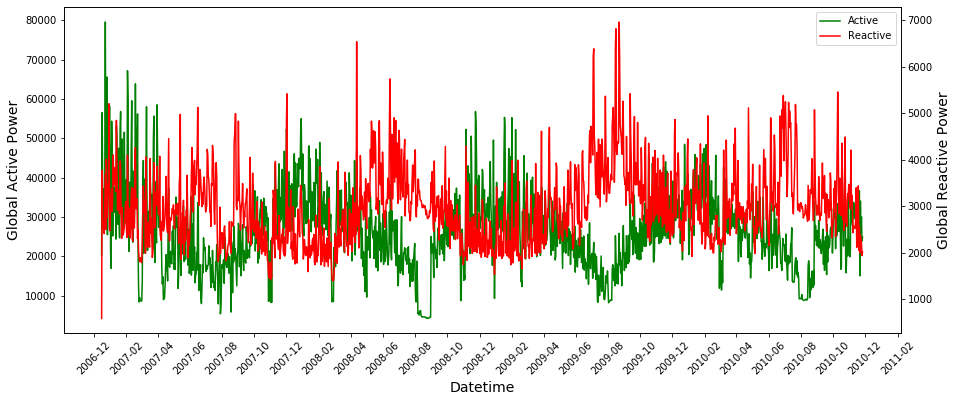

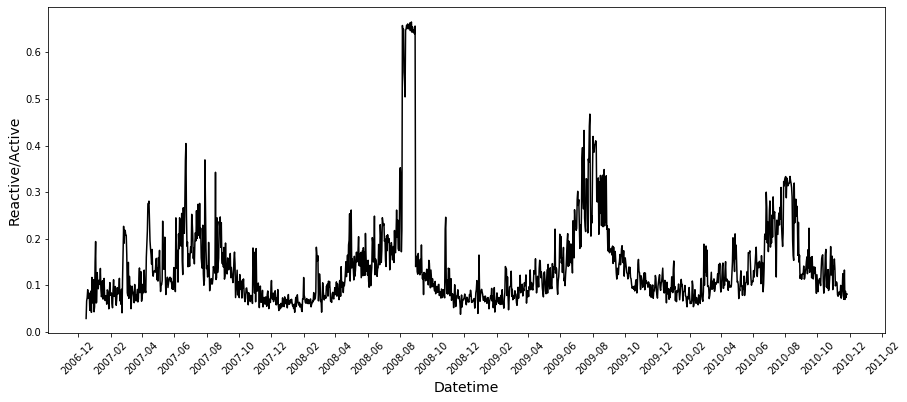

In [10]:
# Plot the active and reactive power
fig, ax = plt.subplots(1,1,figsize=(15,6))
line1 = ax.plot(house_power['Datetime'].values, house_power['Global_active_power'], 'g-', label='Active')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Global Active Power', fontsize=14)

ax1 = ax.twinx()
line2 = ax1.plot(house_power['Datetime'].values, house_power['Global_reactive_power'], 'r-', label='Reactive')
ax1.set_ylabel('Global Reactive Power', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(months_fmt)
ax.tick_params(axis='x', rotation=45)

## Add legend
lines = line1+line2
labs = [l.get_label() for l in lines]
plt.legend(lines, labs, loc=1)

#Look at the ratio
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Global_reactive_power']/house_power['Global_active_power'], 'k-')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Reactive/Active', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', rotation=45)

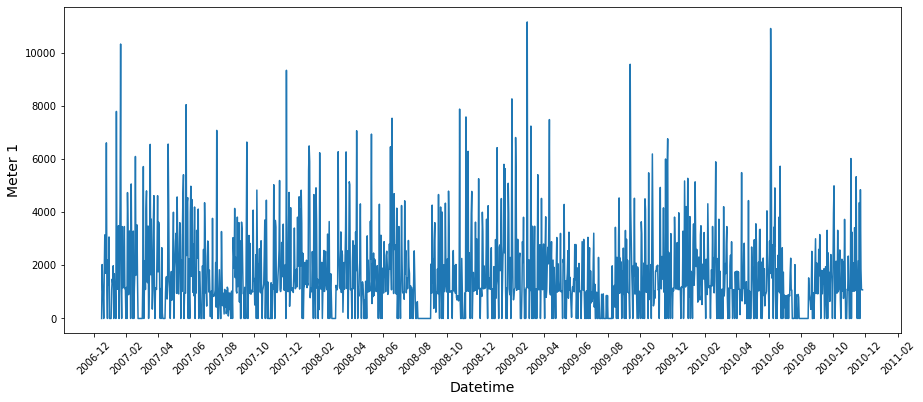

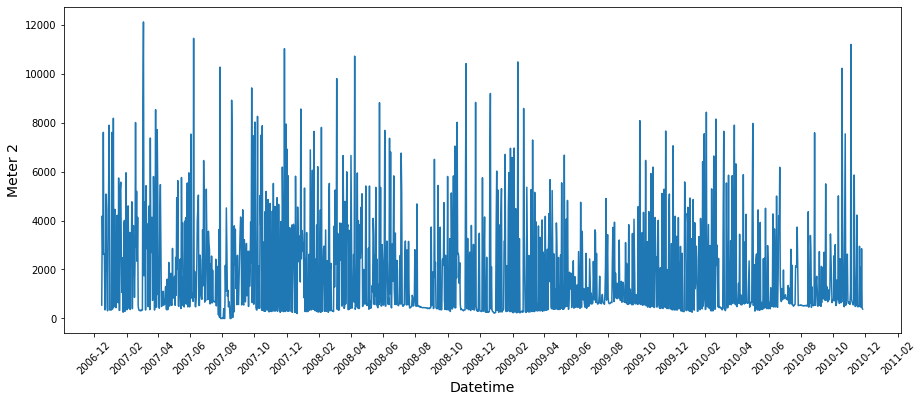

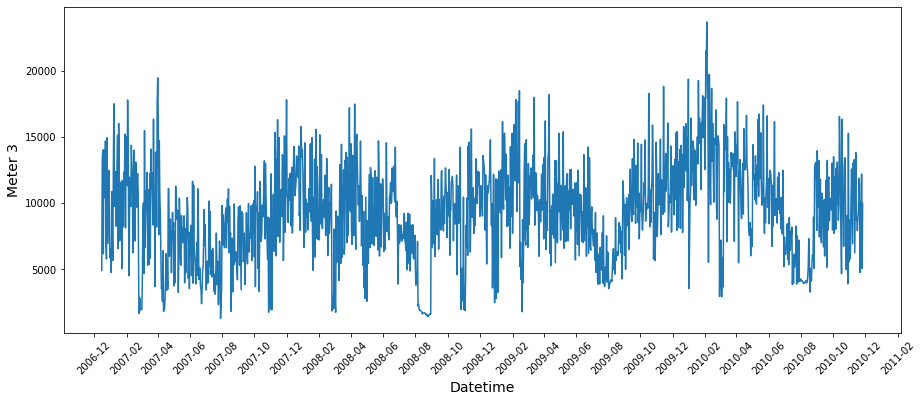

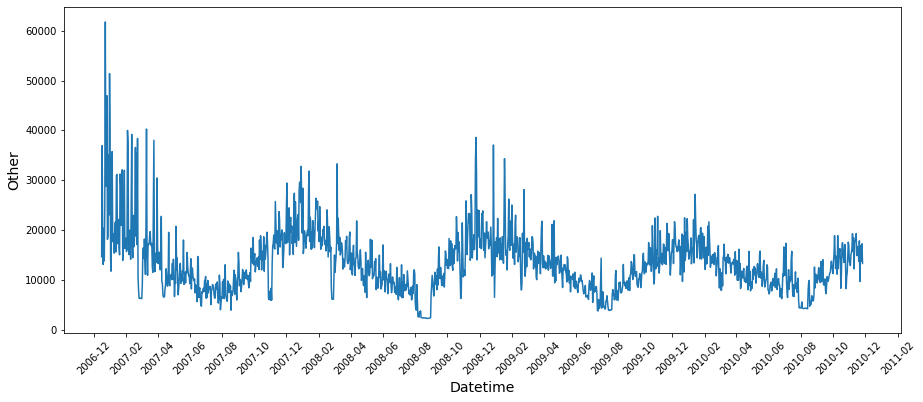

In [11]:
# Look at the sub_meter1
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_1'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 1', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', rotation=45)

# Look at the sub_meter2
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_2'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 2', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', rotation=45)

# Look at the sub_meter3
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Sub_metering_3'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Meter 3', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', rotation=45)

# Look at the rest of power
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(house_power['Datetime'].values,house_power['Other'].values)
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Other', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', rotation=45)

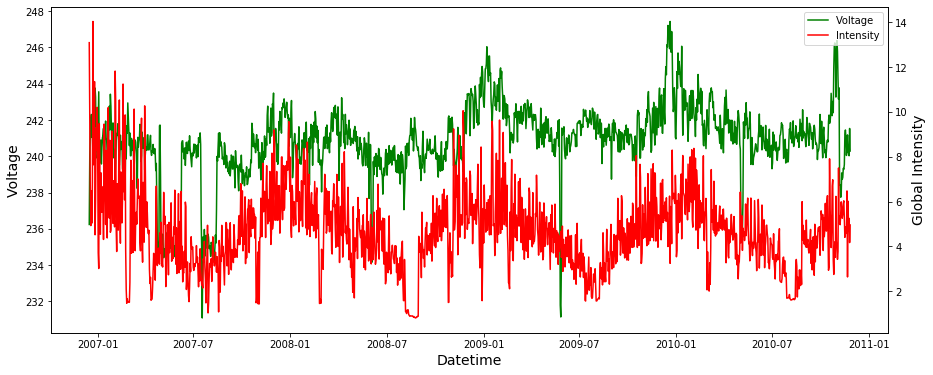

In [12]:
# Look at the Voltage and Intensity
fig, ax = plt.subplots(1,1,figsize=(15,6))
line1 = ax.plot(house_power['Datetime'].values, house_power['Voltage'], 'g-', label='Voltage')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Voltage', fontsize=14)

months = mdates.MonthLocator(interval=2)
months_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax1 = ax.twinx()
line2 = ax1.plot(house_power['Datetime'].values, house_power['Global_intensity'], 'r-', label='Intensity')
ax1.set_ylabel('Global Intensity', fontsize=14)

# added these three lines
lines = line1+line2
labs = [l.get_label() for l in lines]

plt.legend(lines, labs, loc=1)

### A few points based on the visualization of the binned data
1. Sub-meter 3 does not exhibit dramatic increase after binning to daily measurement.
2. Seasonality is more obvious.
3. Still some fluctuation, but not sure entirely noise. 

## Correlation Analysis and Predict Global Active Power

Text(0.5, 1.05, 'Correlation Matrix')

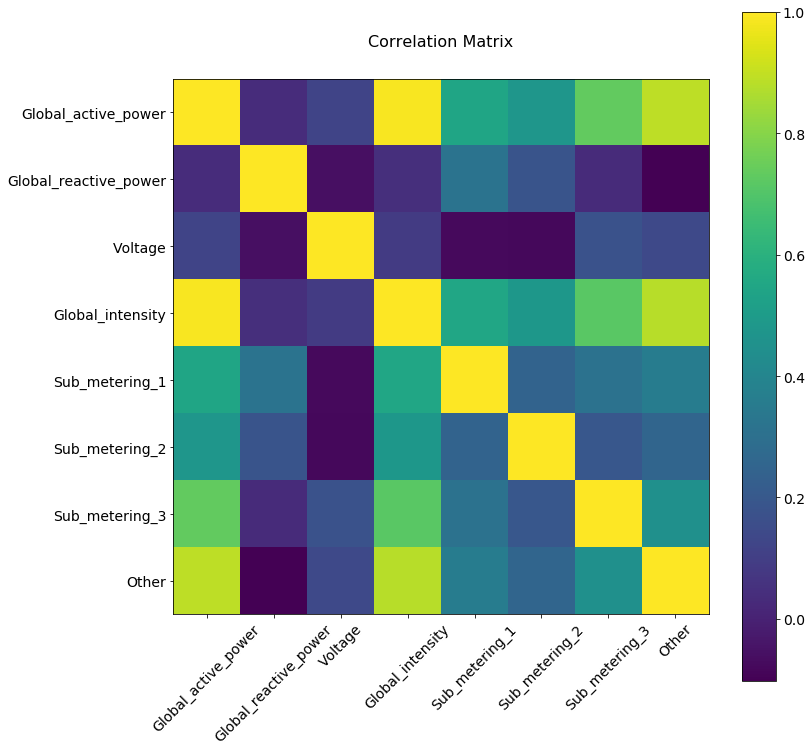

In [13]:
# Plot the heatmap of the correlation among the measurements
fig = plt.figure(figsize=(12, 12))
plt.matshow(house_power.iloc[:,1:].corr(), fignum=fig.number)
plt.xticks(range(house_power.shape[1]-1), house_power.columns[1:], fontsize=14, rotation=45)
plt.yticks(range(house_power.shape[1]-1), house_power.columns[1:], fontsize=14)
plt.gca().xaxis.tick_bottom()
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [14]:
# Divide the data into train and test
train_idx = house_power['Datetime']<np.datetime64('2010-01-01')
test_idx = house_power['Datetime']>=np.datetime64('2010-01-01')
train_x = house_power[train_idx][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
test_x = house_power[test_idx][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
train_y = house_power[train_idx]['Global_active_power']
test_y = house_power[test_idx]['Global_active_power']

In [15]:
alphas = np.asarray([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1])
lr = RidgeCV(alphas=alphas, normalize=True, cv=5)
lr.fit(train_x, train_y)

RidgeCV(alphas=array([0.001, 0.003, 0.01 , 0.03 , 0.1  , 0.3  , 1.   ]), cv=5,
        fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
        store_cv_values=False)

In [16]:
# Check the key metrics to see if obvious overfitting
print("Score:")
print("\t Train: {}, Test: {}".format(lr.score(train_x, train_y), lr.score(test_x, test_y)))
print("MAE:")
print("\t Train: {}, Test: {}".format(mean_absolute_error(lr.predict(train_x), train_y), mean_absolute_error(lr.predict(test_x), test_y)))

Score:
	 Train: 0.7236746703793026, Test: 0.7284060342474007
MAE:
	 Train: 3889.0664816162007, Test: 3526.576439125105


Text(0.5, 1.0, 'Test')

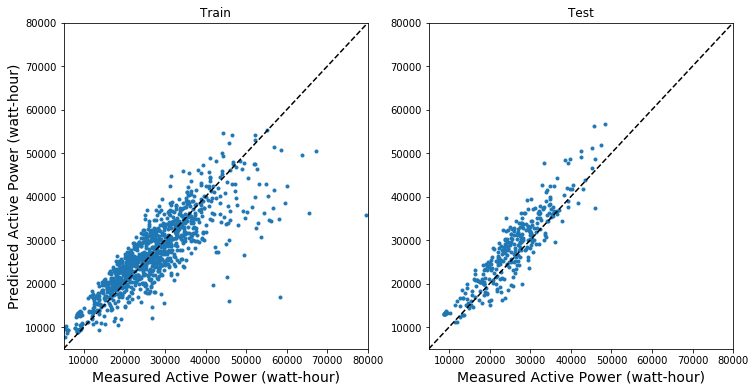

In [17]:
# Plot the Predicted vs. measured
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(train_y, lr.predict(train_x), '.')
axs[0].plot([5000, 80000], [5000, 80000], 'k--')
axs[0].set_xlim(5000, 80000)
axs[0].set_ylim(5000, 80000)
axs[0].set_xlabel('Measured Active Power (watt-hour)', fontsize=14)
axs[0].set_ylabel('Predicted Active Power (watt-hour)', fontsize=14)
axs[0].set_title('Train')

axs[1].plot(test_y, lr.predict(test_x), '.')
axs[1].plot([5000, 80000], [5000, 80000], 'k--')
axs[1].set_xlim(5000, 80000)
axs[1].set_ylim(5000, 80000)
axs[1].set_xlabel('Measured Active Power (watt-hour)', fontsize=14)
axs[1].set_title('Test')

### A few comments on the regression analysis
&emsp; It is common to explore how the measurements correlate to each other <br />
&emsp; Most of power being actively consumed is not measured by any of three sub-meters <br />
&emsp; Regardless, there no obvious overfitting on the test data based on R2 and MAE <br />
&emsp; It may not much meaningful to predict the Global Active Power because we could directly measure it and it should be strongly related to Voltage x Intensity. This is just for fun

## Look at Some Temporal Patterns

### How often do they wash dishes?

Text(0, 0.5, 'Autocorrelation')

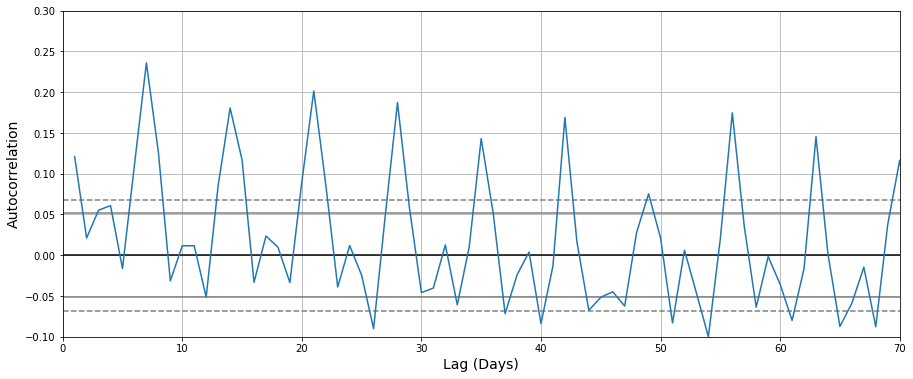

In [18]:
# Look at the autocorrelation
fig = plt.figure(figsize=(15,6))
ax = autocorrelation_plot(house_power['Sub_metering_1'].tolist())
ax.set_ylim(-0.1, 0.3)
ax.set_xlim(0, 70)
# ax.set_xscale('log')
ax.set_xlabel('Lag (Days)', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

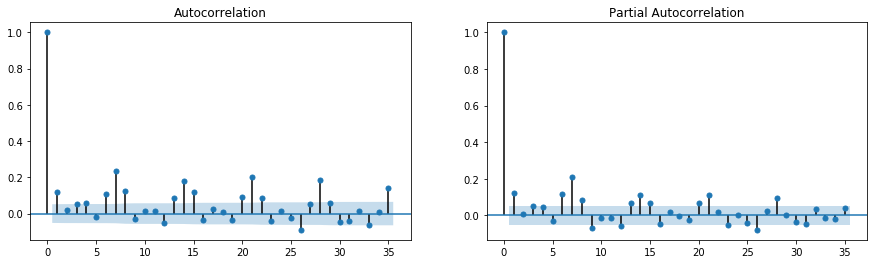

In [19]:
# Look at up to 50 days lag from the autocorrelation and partial autocorrelation
fig, axes = plt.subplots(1,2,figsize=(15,4))
fig = plot_acf(house_power['Sub_metering_1'].tolist(), lags=35, ax=axes[0])
fig = plot_pacf(house_power['Sub_metering_1'].tolist(), lags=35, ax=axes[1])

Text(0, 0.5, 'Residual')

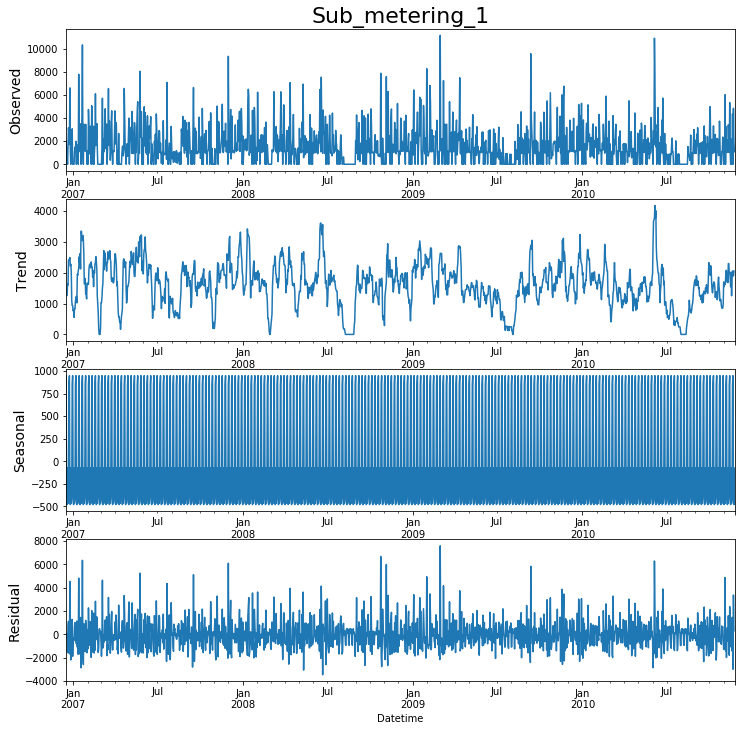

In [20]:
# Look at the trend and seasonality

fig, axs = plt.subplots(4, 1, figsize=(12,12))
result = seasonal_decompose(house_power.set_index('Datetime')['Sub_metering_1'], model='additive')
result.observed.plot(ax=axs[0])
axs[0].set_ylabel('Observed', fontsize=14)
axs[0].set_title('Sub_metering_1', fontsize=22)

result.trend.plot(ax=axs[1])
axs[1].set_ylabel('Trend', fontsize=14)

result.seasonal.plot(ax=axs[2])
axs[2].set_ylabel('Seasonal', fontsize=14)
# axs[2].set_xlim(np.datetime64('2007-01-01'), np.datetime64('2007-02-01'))

result.resid.plot(ax=axs[3])
axs[3].set_ylabel('Residual', fontsize=14)

### By looking at the temporal characteristics of Sub_metering_1, it seems that there are some repeated patterns every 7 days
1. There are spikes every 7 days on the autocorrelation plots.
2. The partial autocorrelation plot shows higher contribution from 7th day lag.
3. Not much trend observed, but the seasonal component seems to repeat every week or so

#### Therefore, it may imply that they wash their dishes using the dishwasher every week or so.

## Vacation or Vacancy?

In [21]:
# Interested in a longer period characteristics, further smooth the data by rolling median
# 15d is arbitrarily selected
house_power = house_power.set_index('Datetime').rolling('15d').median().reset_index()

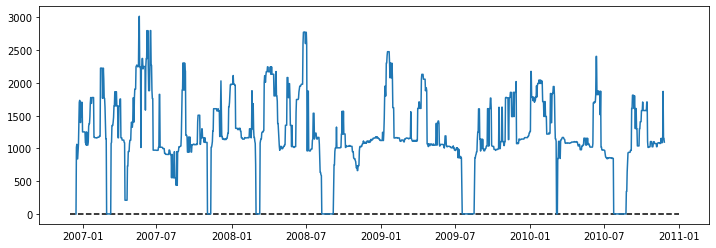

In [22]:
# Plot the time series of Sub_metering_1 after smoothing
fig = plt.figure(figsize=(12,4))
plt.plot(house_power['Datetime'], house_power['Sub_metering_1'])
plt.hlines(0, np.datetime64('2006-12-01'), np.datetime64('2010-12-31'), linestyle='dashed')

In [23]:
# Look for the time period that no power comsuption in the kitchen
idx = house_power[house_power['Sub_metering_1']==0].index

dips = []

for i in range(len(idx)):
    if i==0:
        left = idx[i]
        right = idx[i]
    else:
        if (idx[i] - right)==1:
            right = idx[i]
            if i==(len(idx)-1) and (right-left)>3:
                dips.append((left, right))
        else:
            if (right-left)>3:
                dips.append((left, right))
                left = idx[i]
                right = idx[i]
            else:
                left = idx[i]
                right = idx[i]

In [24]:
# Extract the key infomation about vacancy 
vac_period = 0
vac_idx = 1
for dip in dips:
    vac_period += dip[1] - dip[0]
    print('Vac#{}: {} to {}'.format(vac_idx, house_power.iloc[dip[0]]['Datetime'].date(), house_power.iloc[dip[1]]['Datetime'].date()))
    vac_idx += 1
    
print('Total Vacancy Period: {} days; Vacancy Rate: {:.2f}%'.format(vac_period, vac_period/house_power.shape[0]*100))

Vac#1: 2007-03-01 to 2007-03-11
Vac#2: 2007-11-03 to 2007-11-11
Vac#3: 2008-03-01 to 2008-03-10
Vac#4: 2008-08-09 to 2008-09-06
Vac#5: 2009-07-19 to 2009-08-16
Vac#6: 2010-07-26 to 2010-08-24
Total Vacancy Period: 112 days; Vacancy Rate: 7.77%


### A few points about Vacation/Vacancy
1. The reason to choose Sub_metering_1 (kitchen) for this analysis is because the power in the kitchen could go to zero when it is vacant (also because I like cooking myself), but Sub_metering_2 (because of refridgator) and Sub_metering_3 (because of water heater) could still have some power consumption.
2. For the similar periods, significant decreases for Sub_metering_2 and Sub_metering_3 were also observed, although not reaching zero.
3. It seems there were three vacancy periods lasting ~10 days and the other three lasting ~30 days. While the first three look like vacation, the the last three look like changing tenants (if this is rental property).
4. In order to know if tenants were changed, power usage pattern before and after the vacancy period(s) should be analyzed (not done here). If the pattern changes, then it may suggest new tenants moved in.
5. If sufficient analysis is done in the future, we may be able to predict how long a property will be vacant and thus the consequent financial influence.